# Detroit 2017 Tax Foreclosure Auction

Detroit, MI collects property taxes annually. Failure to pay your property taxes for two years  in a row will result in a foreclosure. By some estimates, one in three homes in Detroit have been sold in a foreclosure auction in the past ten years. It is shocking how inexpensive those homes are and the loss of value experienced by their owners. The next auction takes place tomorrow (September 17-18, 2018). There will also be a follow up auction in October. Ahead of this auction, we analyze the results of the previous auction.

In [73]:
# imports
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import seaborn as sns
plt.rcParams['figure.figsize'] = (16, 8)

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# this allows plots to appear directly in the notebook
%matplotlib inline

google_api_key = %env GOOGLE_API_KEY

from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.models.glyphs import Patches
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap, figure

In [74]:
def create_polygon(mp):
    try:
        xs = []
        ys = []
        for e in mp[16:-3].split(', '):
            pt = [float(x) for x in e.split(' ')]
            xs.append(pt[0])
            ys.append(pt[1])
        return xs,ys
    except:
        return 0


In [75]:
# read in data
sold = pd.read_csv('data/detroit_tax_auction_2017.csv', index_col='parcel_id')
sold.drop(labels=['Unnamed: 14','px_per_foot'],axis=1,inplace=True)

# replace missing with median values
sold['sqft'] = sold.sqft.replace(0, 4400)
sold['year_built'] = sold.year_built.replace(0, 1938)
sold['px_per_foot'] = sold.winning_bid / sold.sqft
sold['tax_value_per_foot'] = sold.taxable_value / sold.sqft
sold.zipcode = sold.zipcode.astype("str")
sold.year_built = sold.year_built.fillna(1900).astype("int64")

# prepare dataset for mapping
sold.geometry = sold.geometry.apply(create_polygon)

In [76]:
sold.lon = sold.geometry.apply(lambda x: x[0] if x != 0 else 0)
sold.lat = sold.geometry.apply(lambda x: x[1] if x != 0 else 0)

In [79]:
output_file("patch.html")

map_options = GMapOptions(lat=42.39054152988467, lng=-82.99644723680774, map_type="roadmap", zoom=16)
p = gmap(google_api_key, map_options, title="Detroit")

source = ColumnDataSource(
    data=dict(lat=sold.lat.values,
              lon=sold.lon.values)
)

glyph = Patches(xs="lon", ys="lat", fill_color="#fb9a99")
p.add_glyph(source, glyph)

show(p)

In [69]:
sold.lon.iloc[35:37].values

array([ [-82.99644723680774, -82.99608681750215, -82.99598439865498, -82.9963435693297, -82.99639479852861, -82.99644723680774],
       [-83.19084425238597, -83.19064919089071, -83.1906323825473, -83.19082744273456, -83.19084425238597]], dtype=object)

In [8]:
print("Total amount raised in the auction ${:.6}M".format( sold.winning_bid.sum() / 1000000 ))
print("Num of homes sold %i and average price per home $%i" % (len(sold), sold.winning_bid.mean()))

Total amount raised in the auction $31.8996M
Num of homes sold 3912 and average price per home $8154


In [9]:
sold.head()

,address,zipcode,winning_bid,acreage,building_type,floor_area,land_value,last_sale,sqft,taxable_value,year_built,geometry,px_per_foot,tax_value_per_foot
parcel_id,,,,,,,,,,,,,,
22059336.027,9136 METTETAL,48228.0,8100,0.0,SINGLE FAMILY,1690.0,600.0,19122.0,4400.0,7500.0,1950,"([-83.20555082527493, -83.20462594453893, -83....",1.840909,1.704545
9008057,601 E STATE FAIR,48203.0,16000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900,0,NaN,NaN
21072244.004L,9590 WHITTIER,48224.0,5200,0.0,APT FLAT GARDEN,760.0,300.0,11500.0,4400.0,4000.0,1958,"([-82.94652589772737, -82.94655084922228, -82....",1.181818,0.909091
22059336.03,9150 METTETAL,48228.0,5700,0.0,SINGLE FAMILY,1704.0,600.0,1000.0,4400.0,7500.0,1950,"([-83.2055472591867, -83.2046223787861, -83.20...",1.295455,1.704545
7001957.07,1941 ORLEANS,nan,50000,0.0,APT FLAT GARDEN,958.0,300.0,7000.0,4400.0,14400.0,1966,"([-83.03574369701136, -83.03433476725849, -83....",11.363636,3.272727


The median house sold for just \$5,200 at the auction, averaged 4,400 square feet and a tenth of an acre in land, and was built in 1938 (around the peak of downtown Detroit expansion). The highest winning bid was $301,000 but there were only a handful of properties into six figures.

In [10]:
sold[['winning_bid','sqft','px_per_foot','tax_value_per_foot', 'floor_area', 'acreage', 'last_sale','year_built']].describe()

,winning_bid,sqft,px_per_foot,tax_value_per_foot,floor_area,acreage,last_sale,year_built
count,3912.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3.911000e+03,3912.000000
mean,8154.290900,5125.544168,1.695135,2.040470,1312.104065,0.117459,2.365117e+04,1936.519172
std,12408.642921,10756.666290,1.920709,1.498746,2091.746488,0.246996,6.430961e+04,13.437227
min,500.000000,958.000000,0.023765,0.000000,0.000000,0.000000,0.000000e+00,1865.000000
25%,2200.000000,3790.000000,0.501495,1.369917,890.000000,0.087000,2.072500e+03,1926.000000
50%,5200.000000,4400.000000,1.161826,1.833444,1080.000000,0.101000,1.000000e+04,1938.000000
75%,9202.500000,5140.000000,2.052205,2.456623,1408.000000,0.118000,2.700000e+04,1948.000000
max,301000.000000,554737.000000,18.363940,33.361474,104896.000000,12.735000,3.100000e+06,1994.000000


In [11]:
# filter out the handful of properties that sell over thirty grand or are unusually large
df = sold[(sold.sqft < 7000) & (sold.winning_bid < 30000)]

Looking at the histogram we can see that the minimum bid of \$500 won over 600 times. Seems like it's worth putting in the minimum bid on every property offered. There is a sharp decline in bids over five grand. Given the historic location, most homes are quite old. Given their owners couldn't pay their property taxes in years, there is probably a lot of deferred maintenance to consider when bidding. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114e45c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115043a90>]], dtype=object)

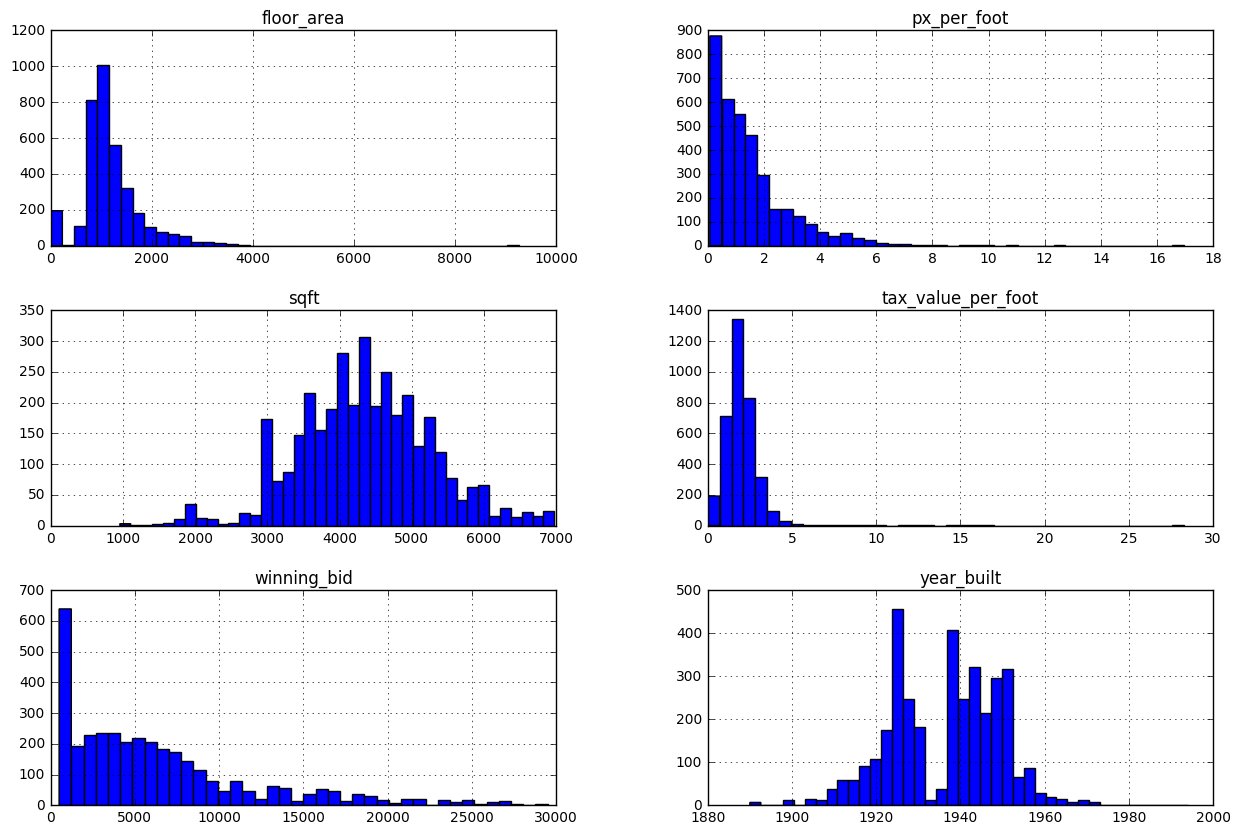

In [12]:
df[['winning_bid','sqft', 'floor_area','px_per_foot','tax_value_per_foot', 'year_built']].hist(bins=40,figsize=(15,10))

Correlating the variables, we see correlation between the price and floor area and assessed taxable value. 

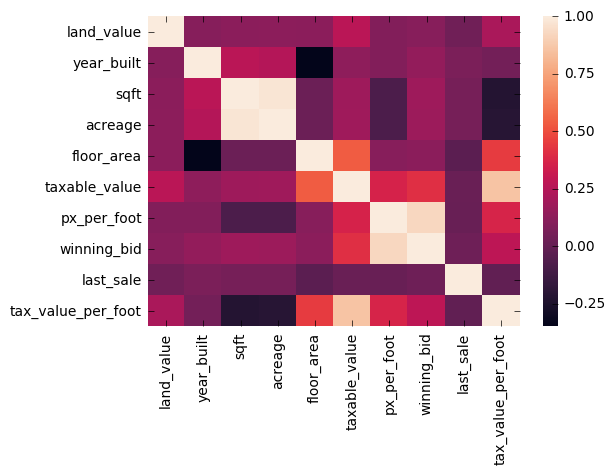

In [13]:
# Calculate and plot
numerical = list(set(df.columns) - set(['address','building_type']))

corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix);

Surprisingly, there isn't a lot of correlation to traditional measures of real estate value like square footage, acreage. Instead bidders appear to just be taking the tax value and dividing it in half.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


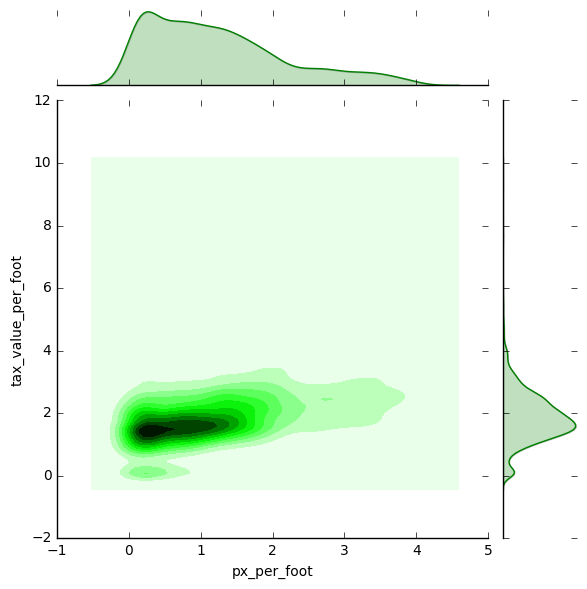

In [14]:
sns.jointplot('px_per_foot', 'tax_value_per_foot', data=df[(df.px_per_foot < 4) & (df.tax_value_per_foot < 10)], kind="kde", color="g")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


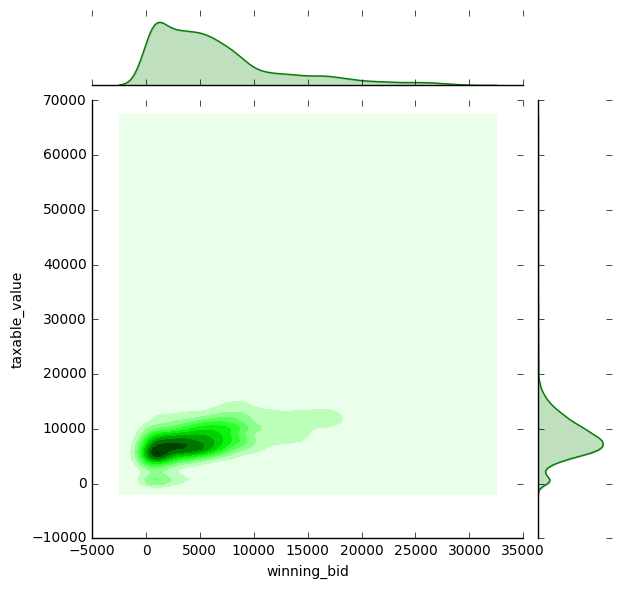

In [15]:
sns.jointplot('winning_bid', 'taxable_value', data=df, kind="kde", color="g")

The winning price in this auction is not related to any of the traditional real estate metrics.

In [16]:
price_model = ols("px_per_foot ~ tax_value_per_foot + sqft + floor_area +  acreage + year_built", data=df).fit()
# summarize our model
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            px_per_foot   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     120.6
Date:                Sun, 16 Sep 2018   Prob (F-statistic):          3.29e-118
Time:                        20:26:26   Log-Likelihood:                -6053.0
No. Observations:                3573   AIC:                         1.212e+04
Df Residuals:                    3567   BIC:                         1.216e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            -13.7826      3.864     -3.567      0.000       -21.358    -6.207
tax_value_per_foot     0.4315      0.022     19.806      0.000         0.389     0.474
sqft                4.865e-06      0.000      0.041      0.967        -0.000     0.000
floor_area         -7.519e-05   4.49e-05     -1.675      0.094        -0.000  1.28e-05
acreage               -1.0302      4.959     -0.208      0.835       -10.753     8.693
year_built             0.0075      0.002      3.746      0.000         0.004     0.011
==============================================================================
Omnibus:                     1399.974   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14600.836
Skew:                           1.565   Prob(JB):                         0.00
Kurtosis:                      12.396   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""